In [ ]:
# ========================
# STD LIBS (Python nativo)
# ========================
import json
import time
import random
import subprocess
from pathlib import Path
from io import StringIO

# ==========================
# TERCEIROS (dados & web)
# ==========================
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

# ==========================
# SELENIUM (automação web)
# ==========================
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException

# Opções para Firefox
from selenium.webdriver.firefox.options import Options


# ==========================
# VISUALIZAÇÃO (gráficos)
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# ==========================
# JUPYTER MAGIC (Notebook)
# ==========================
%matplotlib inline


In [ ]:


# ========== 1) Iniciar o Tor ==========
try:
    # ajuste o caminho se necessário
    tor_path = r"C:\Tor\Browser\TorBrowser\Tor\tor.exe"
    subprocess.Popen([tor_path])
    print("[INFO] Tor iniciado com sucesso.")
except Exception as e:
    print(f"[ERRO] Falha ao iniciar o Tor: {e}")

# dá um tempo pro Tor subir
time.sleep(10)

# ========== 2) Configurar Firefox via Tor ==========
agentes = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36",
]
agente = random.choice(agentes)

options = Options()
# Proxy SOCKS5 do Tor
options.set_preference("network.proxy.type", 1)
options.set_preference("network.proxy.socks", "127.0.0.1")
options.set_preference("network.proxy.socks_port", 9050)
options.set_preference("network.proxy.socks_remote_dns", True)

# User-Agent custom
options.set_preference("general.useragent.override", agente)

# Pequenas mitigações de detecção (não fazem milagre, mas ajudam)
options.set_preference("dom.webdriver.enabled", False)
options.set_preference("media.peerconnection.enabled", False)  # desabilita WebRTC
options.set_preference("privacy.trackingprotection.enabled", True)

# Headless se quiser (opcional):
# options.add_argument("-headless")

# Se o geckodriver não estiver no PATH, baixe e coloque o .exe no PATH, ou use webdriver-manager
driver = webdriver.Firefox(options=options)

# ========== 3) Abrir e reaproveitar HTML renderizado ==========
try:
    # (opcional) testar o IP via Tor
    driver.get("https://check.torproject.org/")
    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
    print("[INFO] Página de verificação do Tor carregada.")

    api_url = "https://fbref.com/en/comps/24/stats/Serie-A-Stats#all_stats_standard"
    print(f"[1/1] Acessando: {api_url}")
    driver.get(api_url)

    # aguarda aparecer pelo menos 1 tabela
    WebDriverWait(driver, 25).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "table"))
    )

    html = driver.page_source  # HTML da aba atual aberta via Selenium
    table = pd.read_html(StringIO(html))  # lê TODAS as tabelas encontradas

    # pegue ID conforme necessário
    tabela_brasileirao = table[11]
    print(tabela_brasileirao.head())

    # Exportar para CSV
    tabela_brasileirao.to_csv('D:/pythonProject/Tutoriais/data/raw/Player_Standard_Stats_2024_Serie_A.csv', index=False)
    print("Tabela extraída com sucesso!")
    
except Exception as e:
    print(f"[ERRO] Falha no fluxo Selenium+Tor: {e}")
finally:
    driver.quit()  # feche quando terminar
    pass


In [ ]:
tabela_brasileirao

In [ ]:
import pandas as pd

def clean_fbref_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    - Se colunas forem MultiIndex (FBRef), usa o 2º nível (nomes reais).
    - Para colunas cujo 1º nível == 'Per 90 Minutes', adiciona sufixo '_90'.
    - Mantém 'Performance' sem mudanças.
    """
    if not isinstance(df.columns, pd.MultiIndex):
        return df  # nada a fazer

    new_cols = []
    for col in df.columns:
        # col é uma tupla (nivel0, nivel1)
        g = str(col[0]).strip() if len(col) > 1 else ""
        name = str(col[1]).strip() if len(col) > 1 else str(col[0]).strip()

        # Alguns vêm como 'Unnamed: 0_level_0' etc. -> ignora
        if g.lower().startswith("unnamed"):
            g = ""

        # Regra: apenas Per 90 Minutes ganha _90
        if g == "Per 90 Minutes":
            name = f"{name}_90"

        new_cols.append(name)

    df = df.copy()
    df.columns = new_cols
    return df


In [ ]:
#limpando as colunas 
tabela_brasileirao = clean_fbref_cols(tabela_brasileirao)


In [ ]:
tabela_brasileirao

In [ ]:
#salvando tabela cabeçalho limpo
tabela_brasileirao.to_csv('D:/pythonProject/Tutoriais/data/processed/Player_Standard_Stats_2024_Serie_A.csv', index=False)

In [ ]:
serie_a = pd.read_csv('D:/pythonProject/Tutoriais/data/processed/Player_Standard_Stats_2024_Serie_A.csv')

In [ ]:
serie_a.info()

In [ ]:
serie_a.head(4)

In [ ]:
serie_a.tail(4)

In [ ]:
# Excluir a coluna "Matches"
serie_a.drop(columns=["Matches"], inplace=True, errors="ignore")

# Exibir as primeiras linhas para confirmar as alterações
display(serie_a.head())

In [ ]:
serie_a.info()

In [ ]:

def convert_fbref_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ---- 1. Colunas categóricas (texto) ----
    text_cols = ["Player", "Nation", "Pos", "Squad"]

    # ---- 2. Coluna Rk -> int ----
    df["Rk"] = pd.to_numeric(df["Rk"], errors="coerce").astype("Int64")

    # ---- 3. Coluna Born -> ano (int) ----
    df["Born"] = pd.to_numeric(df["Born"], errors="coerce").astype("Int64")

    # ---- 4. Coluna Age -> anos + dias/365 ----
    def parse_age(age_str):
        try:
            years, days = age_str.split("-")
            val = int(years) + int(days) / 365
            return round(val, 2)   # arredonda para 2 casas decimais
        except:
            return pd.NA

    df["Age"] = df["Age"].astype(str).apply(parse_age).astype("Float64")

    # ---- 5. Todas as outras colunas (numéricas) ----
    num_cols = [c for c in df.columns if c not in text_cols + ["Rk", "Born", "Age"]]
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").astype("Float64")

    return df


In [ ]:
serie_a = convert_fbref_dtypes(serie_a)

In [ ]:
serie_a

In [ ]:
display(serie_a.dtypes)

In [ ]:
serie_a.isna().sum()

In [ ]:
# Mostra apenas as linhas com pelo menos 1 NaN
df_nulls = serie_a[serie_a.isna().any(axis=1)]
print(df_nulls.shape)   
df_nulls.head()


# Esses foram os cabecalhos de mudança de tabela, vamos excluir

In [ ]:
# remove linhas onde Rk está vazio
serie_a = serie_a.dropna(subset=["Rk"]).reset_index(drop=True)


In [ ]:
serie_a.isna().sum()

In [ ]:
# Total Goals - Non Penalt
Total_Goals = serie_a['G-PK'].sum()
print(Total_Goals)

In [ ]:
# Penalty Goals
Total_PenatyGoals = serie_a['PK'].sum()
print(Total_PenatyGoals)

In [ ]:
# Penalty Attempts
Total_PenaltyAttempts = serie_a['PKatt'].sum()
print(Total_PenaltyAttempts)

In [ ]:
# Pie chart for penalties vs scored
plt.figure(figsize=(13, 6))
plt_not_scored = serie_a['PKatt'].sum() - Total_PenatyGoals
data = [plt_not_scored, Total_PenatyGoals]
labels = ['Penalties Missed', 'Penalties Scored']
color = sns.color_palette('Set2')

# Create the pie chart
plt.pie(data, labels=labels, colors=color, autopct='%.0f%%')

# Add the title
plt.title('Penalty Conversion in Serie A', fontsize=16)

# Show the chart
plt.show()

In [ ]:
# Unique positions

serie_a['Pos'].unique()

In [ ]:
# Total FW Players

serie_a[serie_a['Pos'] == 'FW']

In [ ]:
# Players from different nations

np.size((serie_a['Nation'].unique()))

In [ ]:
# Most players from which countries

# Grouping and sorting the data
nationality = serie_a.groupby('Nation').size().sort_values(ascending=False)

# Create the bar plot
ax = nationality.head(10).plot(kind='bar', figsize=(12, 6), color=sns.color_palette("magma"))

# Add values on top of the bars
for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_height())}',  # The value to display
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=12,  # Font size
        color='black'  # Font color
    )

# Add title and labels
ax.set_title('Top 10 Nationalities in Serie A', fontsize=16)
ax.set_xlabel('Nation', fontsize=14)
ax.set_ylabel('Number of Players', fontsize=14)

# Show the plot
plt.show()

In [ ]:
# Remover brasileiros (BRA)
serie_a_no_bra = serie_a[serie_a["Nation"] != "br BRA"]

# Agrupar e ordenar
nationality = serie_a_no_bra.groupby("Nation").size().sort_values(ascending=False)

# Plot top 10
ax = nationality.head(10).plot(
    kind="bar",
    figsize=(12, 6),
    color=sns.color_palette("magma")
)

# Adicionar valores em cima das barras
for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_height())}',
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha="center",
        va="bottom",
        fontsize=12,
        color="black"
    )

# Títulos e rótulos
ax.set_title("Top 10 Nationalities in Serie A (excluding Brazil)", fontsize=16)
ax.set_xlabel("Nation", fontsize=14)
ax.set_ylabel("Number of Players", fontsize=14)

plt.show()


In [ ]:
# Plotting clubs with maximum players in their squad
plt.figure(figsize=(12, 6))
top_clubs = serie_a['Squad'].value_counts().nlargest(5)
ax = top_clubs.plot(kind='bar', color=sns.color_palette("viridis"))

# Add values on top of the bars
for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_height())}',  # Value to display
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=12,  # Font size
        color='black'  # Font color
    )

# Add title and axis labels
ax.set_title('Top 5 Clubs with Maximum Players in Their Squad', fontsize=16)
ax.set_xlabel('Club', fontsize=14)
ax.set_ylabel('Number of Players', fontsize=14)

# Show the plot
plt.show()

In [ ]:
# Plotting clubs with the least players in their squad
plt.figure(figsize=(12, 6))
least_clubs = serie_a['Squad'].value_counts().nsmallest(5)
ax = least_clubs.plot(kind='bar', color=sns.color_palette("viridis"))

# Add values on top of the bars
for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_height())}',  # Value to display
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=12,  # Font size
        color='black'  # Font color
    )

# Add title and axis labels
ax.set_title('Top 5 Clubs with the Least Players in Their Squad', fontsize=16)
ax.set_xlabel('Club', fontsize=14)
ax.set_ylabel('Number of Players', fontsize=14)

# Show the plot
plt.show()

In [ ]:
# Players based on age group

Under20 = serie_a[serie_a['Age'] <= 20]
age20_25 = serie_a[(serie_a['Age'] > 20) & (serie_a['Age'] <= 25)]
age25_30 = serie_a[(serie_a['Age'] > 25) & (serie_a['Age'] <= 30)]
above30 = serie_a[serie_a['Age'] >= 30]

In [ ]:
# Data
x = np.array([Under20['Player'].count(), age20_25['Player'].count(), age25_30['Player'].count(), above30['Player'].count()])
mylabels = ["<=20", ">20 & <=25", ">25 & <=30", ">30"]

# Create a custom color palette
colors = sns.color_palette("pastel")

# Plot the pie chart
plt.figure(figsize=(10, 6))  # Adjust figure size
plt.pie(
    x, 
    labels=mylabels, 
    autopct="%.1f%%", 
    colors=colors, 
    startangle=90,  # Rotate to start at the top
    wedgeprops={'edgecolor': 'black'}  # Add edge color for better contrast
)
plt.title('Age Distribution of Players', fontsize=20, pad=20)  # Add padding to separate the title

# Show the plot
plt.show()

In [ ]:
# Filter players under 20
players_under_20 = serie_a[serie_a['Age'] < 20]

# Count under-20 players in each club
under_20_counts = players_under_20['Squad'].value_counts()

# Plot the data
plt.figure(figsize=(12, 6))
ax = under_20_counts.plot(
    kind='bar', 
    color=sns.color_palette("cubehelix"), 
    edgecolor='black'
)

# Add values on top of the bars
for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_height())}',  # Display the count
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position at the top of the bar
        ha='center', 
        va='bottom', 
        fontsize=11, 
        color='black'
    )

# Add title and axis labels
ax.set_title('Total Under-20 Players in Each Club', fontsize=16)
ax.set_xlabel('Club', fontsize=14)
ax.set_ylabel('Number of Players', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=75, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [ ]:
# Under 20 players in Internacional

players_under_20[players_under_20['Squad'] == 'Internacional']

In [ ]:
# Under 20 players in Palmeiras

players_under_20[players_under_20['Squad'] == 'Palmeiras']

In [ ]:
# Under 20 players in Botafogo (RJ)

players_under_20[players_under_20['Squad'] == 'Botafogo (RJ)']

In [ ]:
# Under 20 players in Atletico Mineiro

players_under_20[players_under_20['Squad'] == 'Atlético Mineiro']

In [ ]:
# Sort clubs by median age
sorted_clubs = (
    serie_a.groupby('Squad')['Age'].median()
    .sort_values(ascending=False)
    .index
)

# Create the figure
plt.figure(figsize=(14, 7))

# Create the boxplot with sorted clubs and a custom palette
sns.boxplot(
    x='Squad', 
    y='Age', 
    data=serie_a, 
    palette='viridis', 
    order=sorted_clubs, 
    showfliers=True  # Set to False to hide outliers if needed
)

# Add quartile lines for better interpretation
plt.axhline(serie_a['Age'].quantile(0.25), color='blue', linestyle='--', label='25th Percentile')
plt.axhline(serie_a['Age'].quantile(0.75), color='green', linestyle='--', label='75th Percentile')
plt.legend()

# Add annotations for median age
median_ages = serie_a.groupby('Squad')['Age'].median()
for index, club in enumerate(sorted_clubs):
    plt.text(
        index, 
        median_ages[club] + 0.5,  # Position the text slightly above the median
        f"{median_ages[club]:.1f}",  # Display median age with 1 decimal
        ha='center', 
        fontsize=10, 
        color='black'
    )

# Customize title and labels
plt.title('Age Distribution of Players in Each Club', fontsize=16, pad=15)
plt.xlabel('Club', fontsize=14)
plt.ylabel('Age', fontsize=14)

# Customize tick labels for readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
num_player = serie_a.groupby('Squad').size()
data = (serie_a.groupby('Squad')['Age'].sum())/ num_player
data = data.round(2)
data.sort_values(ascending = False)

In [ ]:
# Transformar em DataFrame
df_medians = pd.DataFrame(list(data.items()), columns=["Club", "Median_Age"])

# Média da liga
league_mean = df_medians["Median_Age"].mean()

# Ordenar do mais jovem pro mais velho
df_sorted = df_medians.sort_values("Median_Age", ascending=True)

# --- Gráfico ---
fig, ax = plt.subplots(figsize=(8, 8))

# Barras coloridas em gradiente
bars = ax.barh(
    df_sorted["Club"],
    df_sorted["Median_Age"],
    color=plt.cm.viridis_r(
        (df_sorted["Median_Age"] - df_sorted["Median_Age"].min()) /
        (df_sorted["Median_Age"].max() - df_sorted["Median_Age"].min())
    )
)

# Linha da média
ax.axvline(league_mean, color="red", linestyle="--", label=f"Média da Liga ({league_mean:.1f})")

# Valores ao lado das barras
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2,
            f"{width:.1f}", va="center", fontsize=10)

# Títulos e rótulos
ax.set_title("Idade Mediana dos Elencos da Série A", fontsize=14)
ax.set_xlabel("Idade Mediana")
ax.set_ylabel("Clube")
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:

# Identificar top 3 mais jovens e top 3 mais velhos
youngest = df_sorted.head(3)["Club"].tolist()
oldest = df_sorted.tail(3)["Club"].tolist()

# Definir cores
colors = []
for club in df_sorted["Club"]:
    if club in youngest:
        colors.append("green")     # destaque jovens
    elif club in oldest:
        colors.append("red")       # destaque veteranos
    else:
        colors.append("lightgray") # neutro

# --- Gráfico ---
fig, ax = plt.subplots(figsize=(8, 8))

bars = ax.barh(df_sorted["Club"], df_sorted["Median_Age"], color=colors)

# Linha da média
ax.axvline(league_mean, color="blue", linestyle="--", label=f"Média da Liga ({league_mean:.1f})")

# Valores ao lado das barras
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2,
            f"{width:.1f}", va="center", fontsize=10)

# Títulos e rótulos
ax.set_title("Idade Mediana dos Elencos da Série A", fontsize=14)
ax.set_xlabel("Idade Mediana")
ax.set_ylabel("Clube")
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Total assists by club
Assists_by_clubs = pd.DataFrame(serie_a.groupby('Squad', as_index=False)['Ast'].sum())

# Set the theme and figure size
sns.set_theme(style='whitegrid', color_codes=True)
plt.figure(figsize=(20, 8))

# Create the bar plot
ax = sns.barplot(
    x='Squad', 
    y='Ast', 
    data=Assists_by_clubs.sort_values(by='Ast', ascending=False),  # Sort clubs by assists
    palette='Set2'
)

# Add annotations to display values on the bars
for bar in ax.patches:
    ax.annotate(
        format(int(bar.get_height()), ','),
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Center the annotation
        ha='center', 
        va='bottom', 
        fontsize=12
    )

# Customize labels and title
ax.set_xlabel('Club', fontsize=20, labelpad=15)
ax.set_ylabel('Total Assists', fontsize=20, labelpad=15)
plt.xticks(rotation=75, fontsize=12)  # Rotate x-axis labels
plt.yticks(fontsize=12)
plt.title('Total Assists by Each Club', fontsize=24, pad=20)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Top 10 Assists

top_10_assists = serie_a[['Player','Age', 'Squad', 'Ast', 'MP']].nlargest(n=10, columns = 'Ast')
top_10_assists

In [ ]:
# Total goals by club
Goals_by_clubs = pd.DataFrame(serie_a.groupby('Squad', as_index=False)['Gls'].sum())

# Set the theme and figure size
sns.set_theme(style='whitegrid', color_codes=True)
plt.figure(figsize=(20, 8))

# Create the bar plot
ax = sns.barplot(
    x='Squad', 
    y='Gls', 
    data=Goals_by_clubs.sort_values(by='Gls', ascending=False),  # Sort clubs by goals
    palette='rocket'
)

# Add annotations to display values on the bars
for bar in ax.patches:
    ax.annotate(
        format(int(bar.get_height()), ','),  # Format as an integer with commas
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Center the annotation
        ha='center', 
        va='bottom', 
        fontsize=12, 
        color='black'
    )

# Customize labels and title
ax.set_xlabel('Club', fontsize=20, labelpad=15)
ax.set_ylabel('Total Goals', fontsize=20, labelpad=15)
plt.xticks(rotation=75, fontsize=12)  # Rotate x-axis labels
plt.yticks(fontsize=12)
plt.title('Total Goals by Each Club', fontsize=24, pad=20)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import plotly.express as px
from IPython.display import HTML

club_colors = {
    "Flamengo": "red",             # vermelho e preto
    "Cruzeiro": "blue",            # azul
    "Palmeiras": "green",          # verde
    "Botafogo (RJ)": "black",      # preto e branco
    "São Paulo": "darkred",        # vermelho/preto/branco
    "RB Bragantino": "crimson",    # vermelho
    "Corinthians": "gray",         # preto/branco
    "Santos": "white",             # branco/preto
    "Grêmio": "deepskyblue",       # azul/preto/branco
    "Internacional": "firebrick",  # vermelho
    "Atlético Mineiro": "black",   # preto/branco
    "Bahia": "royalblue",          # azul/vermelho/branco
    "Ceará": "dimgray",            # preto/branco
    "Fortaleza": "dodgerblue",     # azul/vermelho/branco
    "Fluminense": "darkgreen",     # verde/grená
    "Vasco da Gama": "black",      # preto/branco
    "Sport Recife": "gold",        # vermelho/preto/amarelo
    "Vitória": "darkred",          # vermelho/preto
    "Juventude": "limegreen",      # verde
    "Mirassol": "yellowgreen"      # amarelo/verde
}


fig = px.treemap(
    serie_a,
    path=["Squad"],
    values="Gls",
    color="Squad",               # a coluna usada para cores
    color_discrete_map=club_colors,
    width=1200,
    height=400,
    title="Total Goals scored per club"
)
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

# Fallback seguro: renderiza inline SEM precisar de nbformat
HTML(fig.to_html(include_plotlyjs="cdn", full_html=False))


In [76]:
# Most goals by players

top_10_goals = serie_a[['Player', 'Age', 'Squad', 'Gls', 'Ast', 'MP', 'Pos']].nlargest(n=10, columns = ['Gls'])
top_10_goals

,Player,Age,Squad,Gls,Ast,MP,Pos
303,Kaio Jorge,23.6,Cruzeiro,15.0,5.0,21.0,FW
146,Giorgian De Arrascaeta,31.25,Flamengo,11.0,10.0,18.0,"MF,FW"
626,Pablo Vegetti,36.88,Vasco da Gama,11.0,1.0,18.0,FW
505,Pedro Raul,28.82,Ceará,7.0,0.0,20.0,FW
508,Reinaldo,35.92,Mirassol,7.0,2.0,18.0,DF
481,Isidro Pitta,26.05,RB Bragantino,6.0,1.0,16.0,FW
341,José López,24.73,Palmeiras,6.0,0.0,17.0,"FW,MF"
86,Martin Braithwaite,34.24,Grêmio,6.0,1.0,16.0,FW
473,Matheus Pereira,29.32,Cruzeiro,5.0,6.0,20.0,"MF,FW"
308,Luciano Juba,26.01,Bahia,5.0,3.0,19.0,DF


C:\Users\Leonardo Barbosa\AppData\Local\Temp\ipykernel_17496\3101136165.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




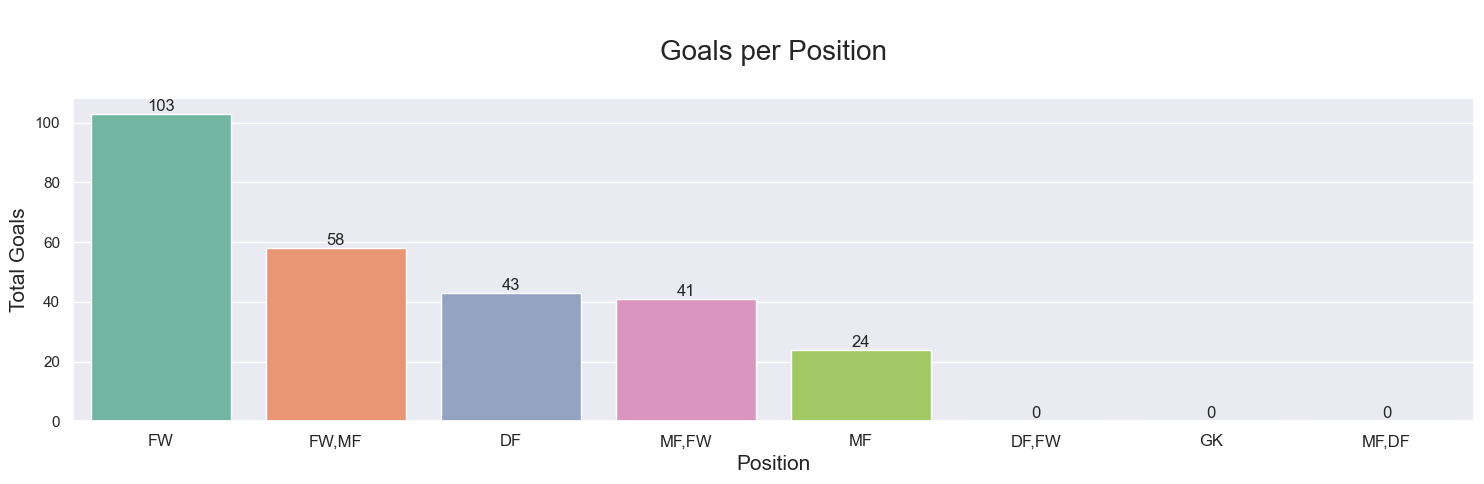

In [77]:
# Configure Seaborn style
sns.set(rc={'figure.figsize': (15, 5)})
plt.xticks(fontsize=12)

# Group by position and sum goals
serie_a_grouped = serie_a.groupby('Pos', as_index=False)['Gls'].sum()

# Sort positions by total goals in descending order
serie_a_grouped = serie_a_grouped.sort_values(by='Gls', ascending=False)

# Create the bar plot
p = sns.barplot(
    data=serie_a_grouped, 
    x='Pos', 
    y='Gls', 
    palette="Set2"
)

# Add values on top of the bars
for bar in p.patches:
    p.annotate(
        format(int(bar.get_height()), ','),  # Format value with commas
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position at top of bar
        ha='center', 
        va='bottom', 
        fontsize=12
    )

# Add title and axis labels
p.axes.set_title("\nGoals per Position\n", fontsize=20)
p.set_xlabel("Position", fontsize=15)
p.set_ylabel("Total Goals", fontsize=15)

# Improve layout and show the plot
plt.tight_layout()
plt.show()

In [78]:
# Create 2 new columns
serie_a['MinsPerMatch'] = (serie_a['Min'] / serie_a['MP']).fillna(0).astype(int)
serie_a['GoalsPerMatch'] = (serie_a['Gls'] / serie_a['MP']).fillna(0).astype(float)
print(serie_a)

      Rk                  Player  Nation    Pos          Squad    Age  Born  \
146  147  Giorgian De Arrascaeta  uy URU  MF,FW       Flamengo  31.25  1994   
303  304              Kaio Jorge  br BRA     FW       Cruzeiro   23.6  2002   
481  482            Isidro Pitta  py PAR     FW  RB Bragantino  26.05  1999   
55    56         Gabriel Barbosa  br BRA  FW,MF       Cruzeiro   29.0  1996   
473  474         Matheus Pereira  br BRA  MF,FW       Cruzeiro  29.32  1996   
..   ...                     ...     ...    ...            ...    ...   ...   
225  226            Agustín Giay  ar ARG     DF      Palmeiras  21.62  2004   
348  349                Zé Lucas  br BRA     MF   Sport Recife  17.44  2008   
174  175         Gonzalo Escobar  ar ARG     DF         Santos  28.46  1997   
572  573             Lucas Sasha  br BRA     MF      Fortaleza   35.5  1990   
555  556           Agustín Rossi  ar ARG     GK       Flamengo  30.03  1995   

       MP  Starts     Min  ...  MinsPerMatch  Goals

In [79]:
# Goals per match
# Filtrar jogadores com mais de 10 jogos

above_10 = serie_a[serie_a['MP'] > 10]
top_10_goals_per_match = above_10[['Player','Age', 'Squad', 'MP', 'Min', 'Gls', 'GoalsPerMatch']].nlargest(n=10, columns = 'GoalsPerMatch')
top_10_goals_per_match

,Player,Age,Squad,MP,Min,Gls,GoalsPerMatch
303,Kaio Jorge,23.6,Cruzeiro,21.0,1628.0,15.0,0.714286
146,Giorgian De Arrascaeta,31.25,Flamengo,18.0,1324.0,11.0,0.611111
626,Pablo Vegetti,36.88,Vasco da Gama,18.0,1459.0,11.0,0.611111
508,Reinaldo,35.92,Mirassol,18.0,1541.0,7.0,0.388889
481,Isidro Pitta,26.05,RB Bragantino,16.0,697.0,6.0,0.375000
86,Martin Braithwaite,34.24,Grêmio,16.0,1342.0,6.0,0.375000
341,José López,24.73,Palmeiras,17.0,873.0,6.0,0.352941
505,Pedro Raul,28.82,Ceará,20.0,1713.0,7.0,0.350000
60,Álvaro Barreal,25.04,Santos,17.0,1181.0,5.0,0.294118
308,Luciano Juba,26.01,Bahia,19.0,1614.0,5.0,0.263158


C:\Users\Leonardo Barbosa\AppData\Local\Temp\ipykernel_17496\4112939588.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




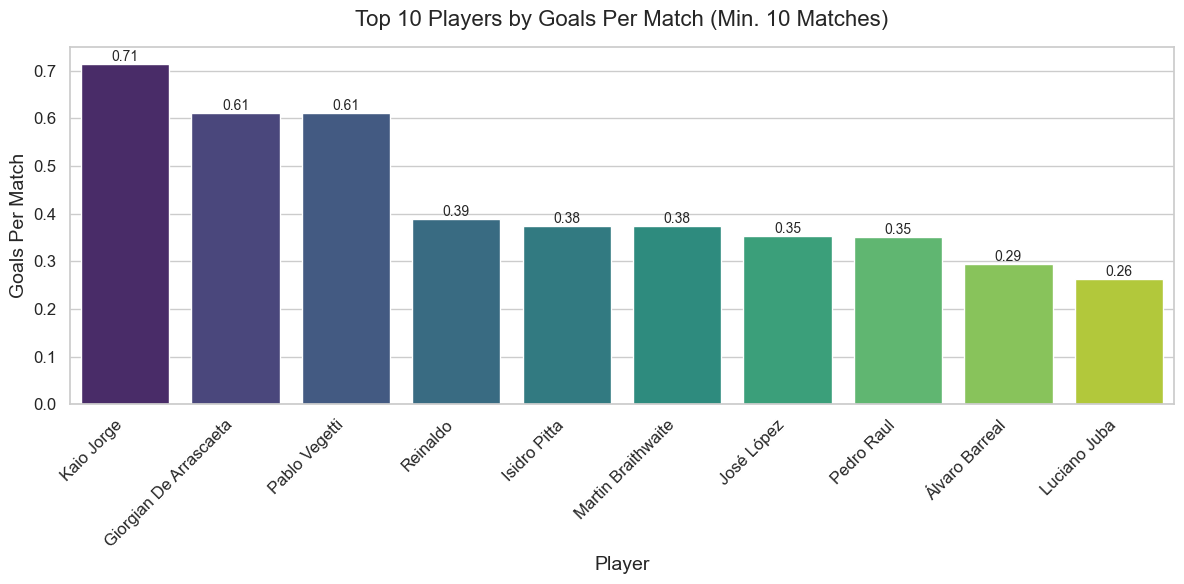

In [80]:
# Filter players with more than 10 matches
above_10 = serie_a[serie_a['MP'] > 10]

# Get the top 10 players by GoalsPerMatch
top_10_goals_per_match = above_10[['Player', 'Squad', 'GoalsPerMatch', 'MP', 'Gls']].nlargest(n=10, columns='GoalsPerMatch')

# Plotting
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Create a bar plot
ax = sns.barplot(
    data=top_10_goals_per_match, 
    x='Player', 
    y='GoalsPerMatch', 
    palette='viridis'
)

# Add values on top of the bars
for bar in ax.patches:
    ax.annotate(
        format(bar.get_height(), '.2f'),  # Display GoalsPerMatch with 2 decimals
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position at the top of the bar
        ha='center', 
        va='bottom', 
        fontsize=10
    )

# Customize the plot
ax.set_title('Top 10 Players by Goals Per Match (Min. 10 Matches)', fontsize=16, pad=15)
ax.set_xlabel('Player', fontsize=14)
ax.set_ylabel('Goals Per Match', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

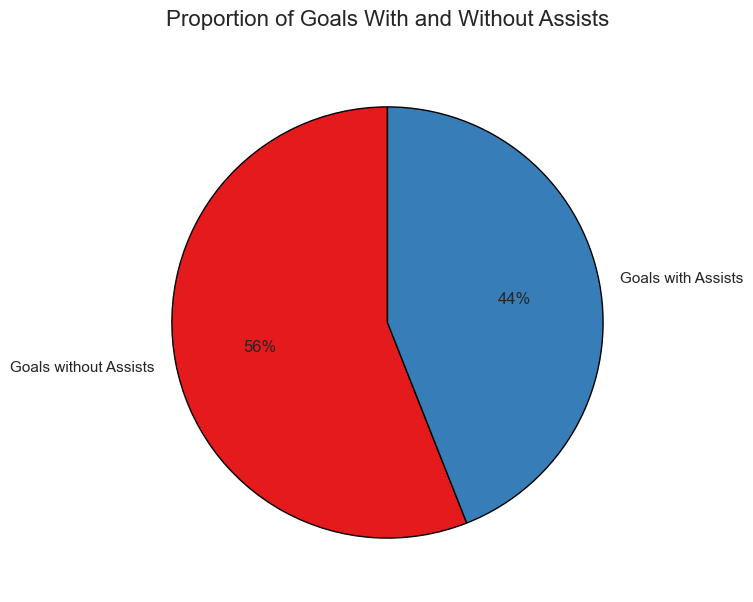

In [81]:
# Data for the pie chart
assists = serie_a['Ast'].sum()
data = [Total_Goals - assists, assists]
labels = ['Goals without Assists', 'Goals with Assists']
colors = sns.color_palette('Set1')

# Create the pie chart
plt.figure(figsize=(14, 7))
plt.pie(
    data, 
    labels=labels, 
    colors=colors, 
    autopct='%.0f%%', 
    startangle=90,  # Start pie at the top
    wedgeprops={'edgecolor': 'black'}  # Add black borders for better contrast
)

# Add a title
plt.title('Proportion of Goals With and Without Assists', fontsize=16, pad=20)

# Show the chart
plt.show()

In [82]:
import plotly.express as px
from IPython.display import HTML

strickers = serie_a[serie_a['Min'] >= 900]

# Criando o scatterplot
fig = px.scatter(
    strickers,
    x="Gls_90",  # Eixo X
    y="xG_90",   # Eixo Y
    text="Player",  # Rótulos com nome dos jogadores
    title="Relação entre Gols e xG",
    labels={"xG_90": "xG (Expected Goals/90)", "Gls_90": "Gols/90"},
    template="plotly_white"
)

# Ajustando posição do texto
fig.update_traces(textposition="top center")

# Exibir inline sem depender de renderer
HTML(fig.to_html(include_plotlyjs="cdn", full_html=False))


C:\Users\Leonardo Barbosa\AppData\Local\Temp\ipykernel_17496\3153921561.py:13: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\Leonardo Barbosa\AppData\Local\Temp\ipykernel_17496\3153921561.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




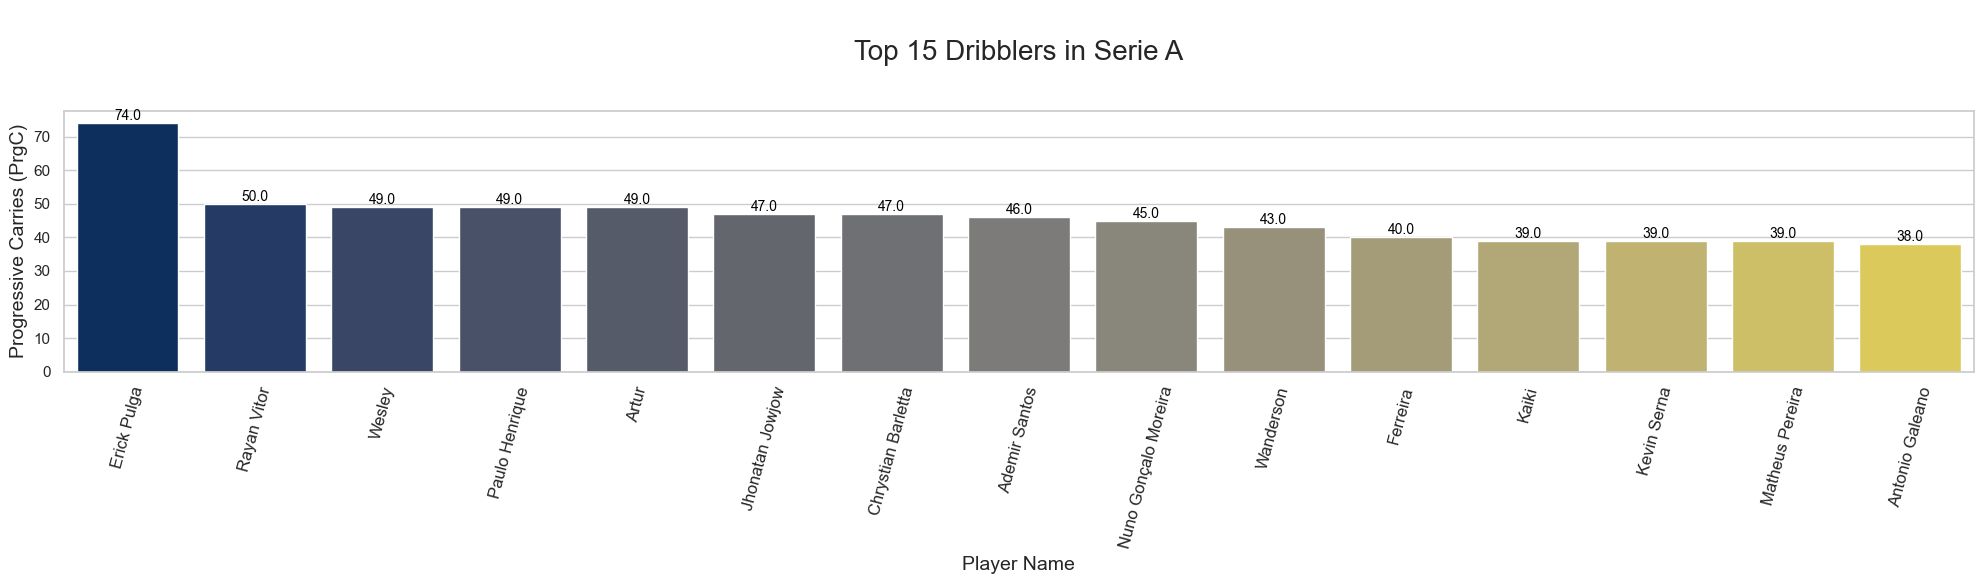

In [83]:
# Sort the dataset by 'PrgC' in descending order
serie_a = serie_a.sort_values(by='PrgC', ascending=False)

# Select the top 15 players
top_dribblers = serie_a[:15]

# Configure Seaborn style and figure size
sns.set(rc={'figure.figsize': (20, 6)})
sns.set_theme(style="whitegrid")
plt.xticks(fontsize=12, rotation=75)

# Create the bar plot without error bars
ax = sns.barplot(
    x="Player", 
    y="PrgC", 
    data=top_dribblers, 
    palette="cividis", 
    capsize=0.2, 
    ci=None  # Disable confidence intervals (error bars)
)

# Add values on top of the bars
for bar in ax.patches:
    ax.annotate(
        format(bar.get_height(), '.1f'), 
        (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black'
    )

# Add title and axis labels
ax.set_title("\nTop 15 Dribblers in Serie A\n", fontsize=20, pad=15)
ax.set_xlabel("Player Name", fontsize=14)
ax.set_ylabel("Progressive Carries (PrgC)", fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

C:\Users\Leonardo Barbosa\AppData\Local\Temp\ipykernel_17496\3184935631.py:13: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\Leonardo Barbosa\AppData\Local\Temp\ipykernel_17496\3184935631.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




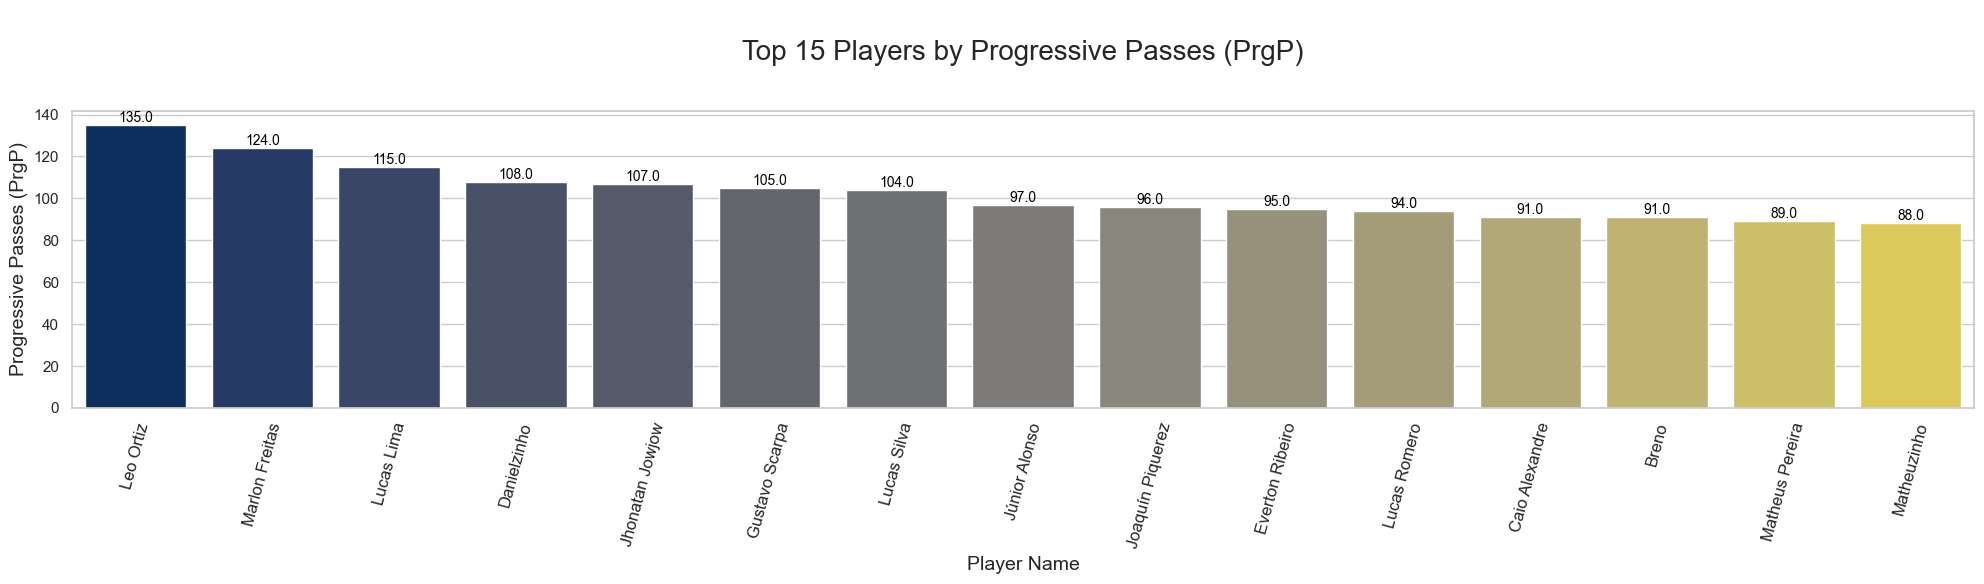

In [84]:
# Sort the dataset by 'PrgP' in descending order
serie_a = serie_a.sort_values(by='PrgP', ascending=False)

# Select the top 15 players
top_passers = serie_a[:15]

# Configure Seaborn style and figure size
sns.set(rc={'figure.figsize': (20, 6)})
sns.set_theme(style="whitegrid")
plt.xticks(fontsize=12, rotation=75)  # Rotate x-axis labels for better readability

# Create the bar plot
ax = sns.barplot(
    x="Player", 
    y="PrgP", 
    data=top_passers, 
    palette="cividis", 
    capsize=0.2, 
    ci=None  # Disable confidence intervals (error bars)
)

# Add values on top of the bars
for bar in ax.patches:
    ax.annotate(
        format(bar.get_height(), '.1f'),  # Display value with one decimal
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position at top of the bar
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black'
    )

# Add title and axis labels
ax.set_title("\nTop 15 Players by Progressive Passes (PrgP)\n", fontsize=20, pad=15)
ax.set_xlabel("Player Name", fontsize=14)
ax.set_ylabel("Progressive Passes (PrgP)", fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [85]:
serie_a.columns.to_list()

['Rk',
 'Player',
 'Nation',
 'Pos',
 'Squad',
 'Age',
 'Born',
 'MP',
 'Starts',
 'Min',
 '90s',
 'Gls',
 'Ast',
 'G+A',
 'G-PK',
 'PK',
 'PKatt',
 'CrdY',
 'CrdR',
 'xG',
 'npxG',
 'xAG',
 'npxG+xAG',
 'PrgC',
 'PrgP',
 'PrgR',
 'Gls_90',
 'Ast_90',
 'G+A_90',
 'G-PK_90',
 'G+A-PK_90',
 'xG_90',
 'xAG_90',
 'xG+xAG_90',
 'npxG_90',
 'npxG+xAG_90',
 'MinsPerMatch',
 'GoalsPerMatch',
 'Gls_norm',
 'Ast_norm',
 'xG_norm',
 'xAG_norm',
 'PrgC_norm',
 'PrgP_norm',
 'PrgR_norm',
 'Score']

C:\Users\Leonardo Barbosa\AppData\Local\Temp\ipykernel_17496\522845019.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




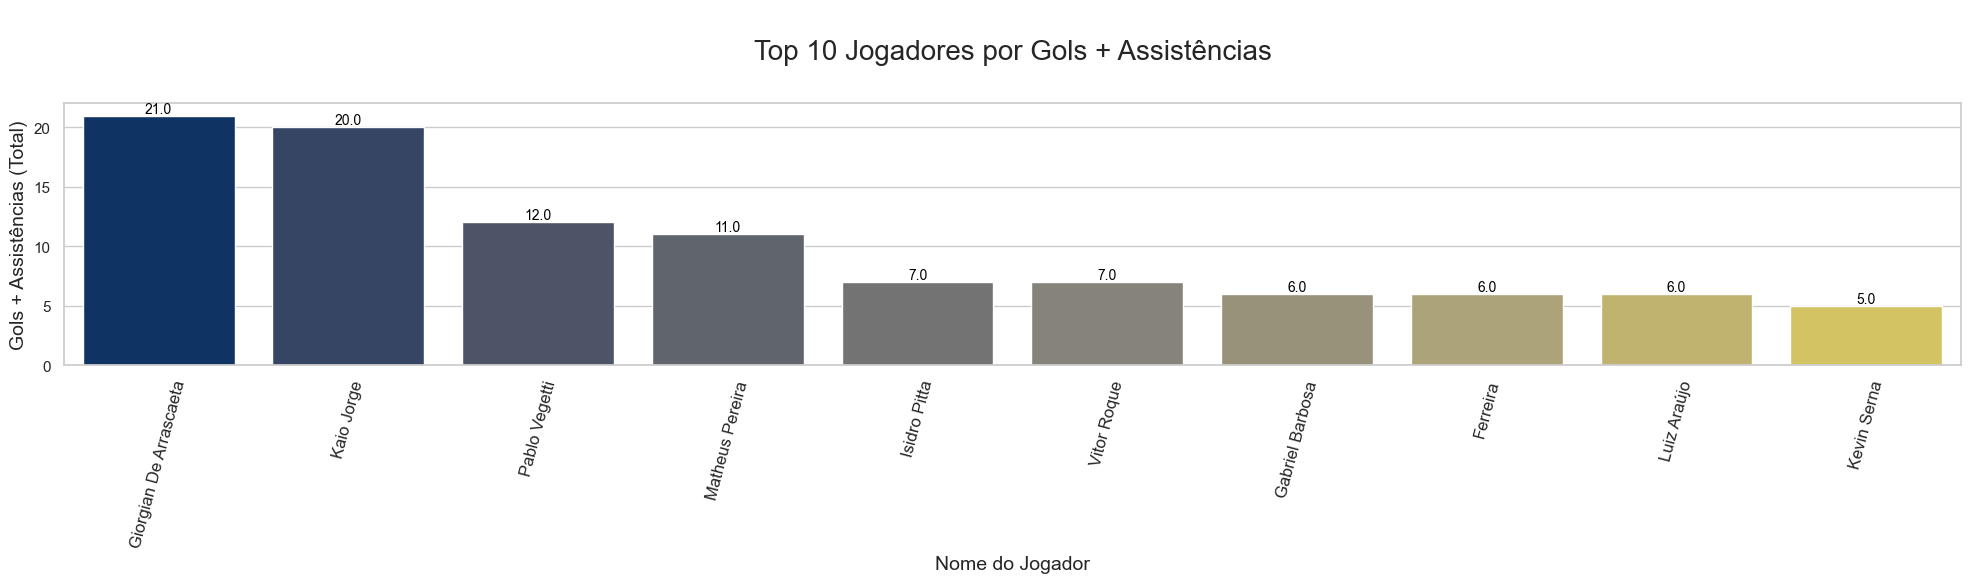

In [ ]:
# A métrica aqui é Gols+Assistências sem pênaltis, por 90 minutos
serie_a_sorted = serie_a.sort_values(by='G+A-PK_90', ascending=False)

# Seleciona os 10 melhores jogadores
top_strickers = serie_a_sorted.head(10)


top_strickers_plot_order = top_strickers.sort_values(by='G+A', ascending=False)


# Configura o estilo e tamanho do gráfico
sns.set_theme(style="whitegrid", rc={'figure.figsize': (20, 6)})
plt.xticks(fontsize=12, rotation=75)

# Cria o gráfico de barras usando o DataFrame reordenado
ax = sns.barplot(
    x="Player",
    y="G+A",
    data=top_strickers_plot_order,  # Usa o DataFrame na ordem correta para o plot
    palette="cividis"
    # O parâmetro `ci=None` foi descontinuado, o padrão já não exibe barras de erro.
)

# Adiciona os valores no topo das barras
for bar in ax.patches:
    ax.annotate(
        format(bar.get_height(), '.1f'),
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Adiciona títulos e rótulos (com nomes mais claros)
ax.set_title("\nTop 10 Jogadores por Gols + Assistências\n", fontsize=20, pad=10)
ax.set_xlabel("Nome do Jogador", fontsize=14)
ax.set_ylabel("Gols + Assistências (Total)", fontsize=14)

# Ajusta o layout e exibe o gráfico
plt.tight_layout()
plt.show()

C:\Users\Leonardo Barbosa\AppData\Local\Temp\ipykernel_17496\2577989732.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Leonardo Barbosa\AppData\Local\Temp\ipykernel_17496\2577989732.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



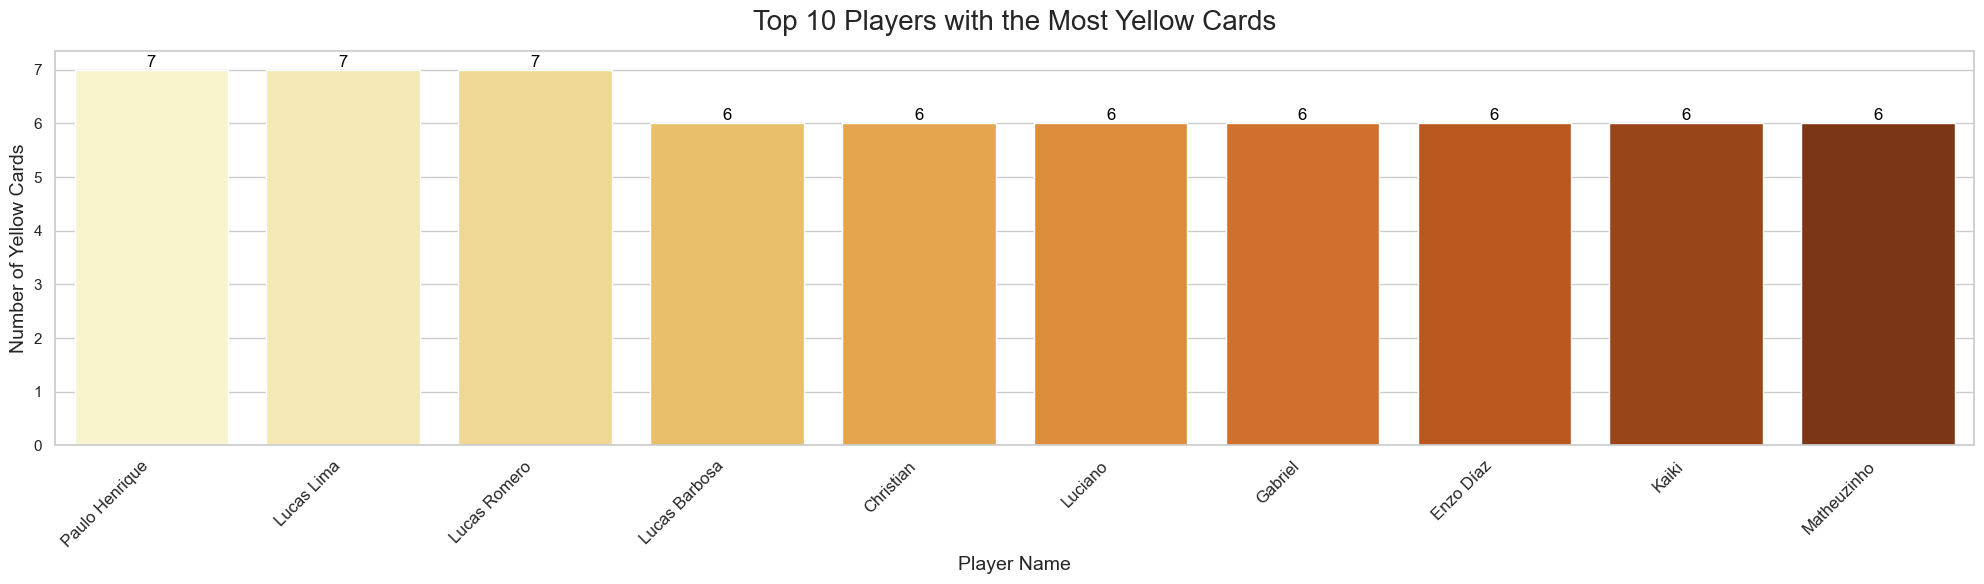

In [88]:
# Sort the dataset by yellow cards and select the top 10 players
serie_a_yellow = serie_a.sort_values(by='CrdY', ascending=False)[:10]

# Configure the figure size and style
plt.figure(figsize=(20, 6))
sns.set_theme(style="whitegrid")

# Create the bar plot
ax = sns.barplot(
    x=serie_a_yellow['Player'], 
    y=serie_a_yellow['CrdY'], 
    palette="YlOrBr"  # Yellow gradient palette
)

# Add annotations for the yellow card counts
for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_height())}',  # Display the yellow card count as an integer
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position above the bar
        ha='center', 
        va='bottom', 
        fontsize=12, 
        color='black'
    )

# Customize the title and axis labels
ax.set_title('Top 10 Players with the Most Yellow Cards', fontsize=20, pad=15)
ax.set_xlabel('Player Name', fontsize=14)
ax.set_ylabel('Number of Yellow Cards', fontsize=14)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

C:\Users\Leonardo Barbosa\AppData\Local\Temp\ipykernel_17496\3797340663.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Leonardo Barbosa\AppData\Local\Temp\ipykernel_17496\3797340663.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



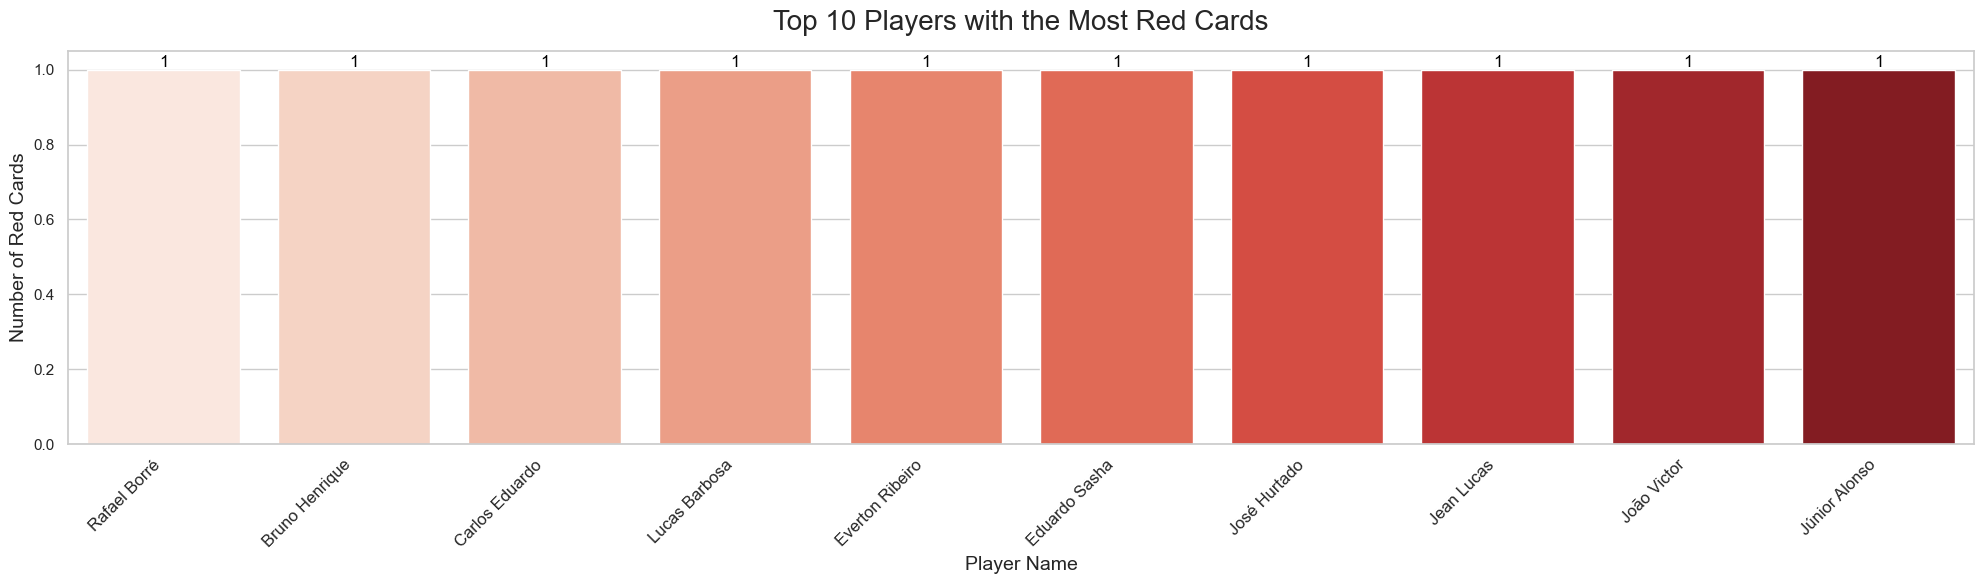

In [91]:
# Sort the dataset by red cards and select the top 10 players
serie_a_red = serie_a.sort_values(by='CrdR', ascending=False)[:10]

# Configure the figure size and style
plt.figure(figsize=(20, 6))
sns.set_theme(style="whitegrid")

# Create the bar plot
ax = sns.barplot(
    x=serie_a_red['Player'], 
    y=serie_a_red['CrdR'], 
    palette="Reds"  # Red gradient palette
)

# Add annotations for the red card counts
for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_height())}',  # Display the red card count as an integer
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position above the bar
        ha='center', 
        va='bottom', 
        fontsize=12, 
        color='black'
    )

# Customize the title and axis labels
ax.set_title('Top 10 Players with the Most Red Cards', fontsize=20, pad=15)
ax.set_xlabel('Player Name', fontsize=14)
ax.set_ylabel('Number of Red Cards', fontsize=14)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Melhores Jogadores

In [94]:
df = pd.read_csv('D:/pythonProject/Tutoriais/data/processed/Player_Standard_Stats_2024_Serie_A.csv')

In [95]:
# Quantos jogos cada clube já disputou
jogos_por_time = serie_a.groupby("Squad")["MP"].max().sort_values(ascending=False)

print(jogos_por_time)


Squad
Ceará               21.0
São Paulo           21.0
RB Bragantino       21.0
Cruzeiro            21.0
Vitória             20.0
Vasco da Gama       20.0
Botafogo (RJ)       20.0
Flamengo            20.0
Santos              20.0
Grêmio              20.0
Juventude           20.0
Bahia               19.0
Atlético Mineiro    19.0
Mirassol            19.0
Corinthians         19.0
Fluminense          19.0
Sport Recife        19.0
Fortaleza           18.0
Internacional       18.0
Palmeiras           18.0
Name: MP, dtype: Float64


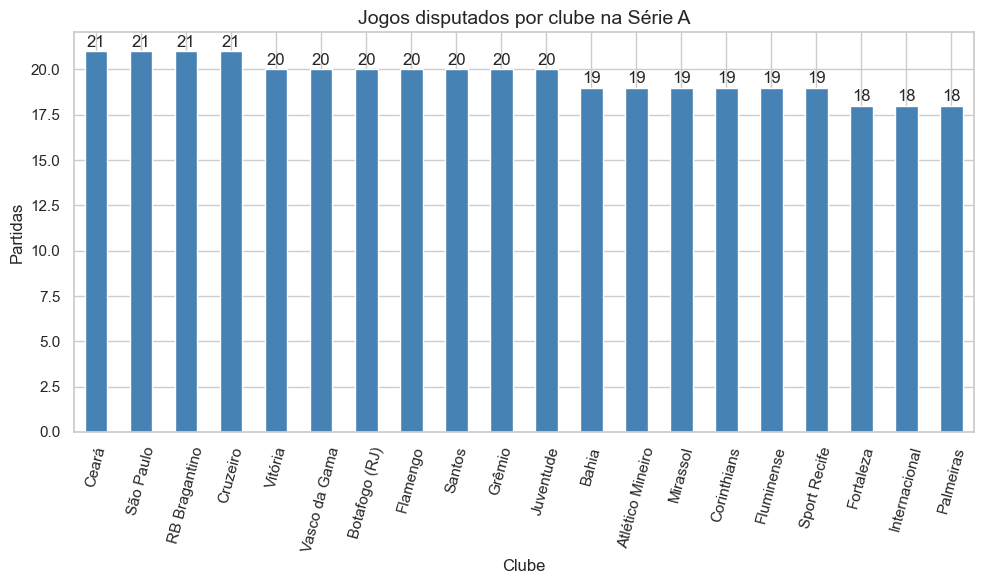

In [96]:
import matplotlib.pyplot as plt

jogos_por_time = serie_a.groupby("Squad")["MP"].max().sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(10,6))
jogos_por_time.plot(kind="bar", color="steelblue", ax=ax)

# Adicionar rótulos em cima
for i, v in enumerate(jogos_por_time):
    ax.text(i, v + 0.1, str(int(v)), ha='center', va='bottom')

ax.set_title("Jogos disputados por clube na Série A", fontsize=14)
ax.set_ylabel("Partidas")
ax.set_xlabel("Clube")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


In [100]:
# Top jogadores com mais jogos
top_jogadores = serie_a.sort_values("Min", ascending=False)[["Player","Pos","Squad","MP","Min"]]

print(top_jogadores.head(15))


                 Player Pos          Squad    MP     Min
116              Cássio  GK       Cruzeiro  21.0  1890.0
93       Fabrício Bruno  DF       Cruzeiro  21.0  1890.0
479        Rafael Pires  GK      São Paulo  21.0  1890.0
152           Dieguinho  MF          Ceará  21.0  1836.0
87       Gabriel Brazão  GK         Santos  20.0  1800.0
646         Tiago Volpi  GK         Grêmio  20.0  1800.0
35        Lucas Arcanjo  GK        Vitória  20.0  1800.0
555       Agustín Rossi  GK       Flamengo  20.0  1800.0
285              Jadson  MF      Juventude  20.0  1791.0
357     Willian Machado  DF          Ceará  20.0  1779.0
312               Kaiki  DF       Cruzeiro  20.0  1776.0
217     Antonio Galeano  FW          Ceará  21.0  1760.0
505          Pedro Raul  FW          Ceará  20.0  1713.0
542        Lucas Romero  MF       Cruzeiro  20.0  1711.0
577  Cleiton Schwengber  GK  RB Bragantino  19.0  1710.0


In [98]:
# Média de jogos por posição
jogos_por_pos = serie_a.groupby("Pos")["MP"].mean().sort_values(ascending=False)
print(jogos_por_pos.round(2))


Pos
GK       19.08
MF,DF     19.0
DF,FW     18.0
MF,FW    17.73
FW       17.54
DF       17.49
FW,MF    17.38
MF       17.33
Name: MP, dtype: Float64


In [99]:
import pandas as pd

def top_n_jogos_por_pos(df, n=5, min_minutos=0):
    d = df.copy()

    # garantir tipos numéricos
    d["MP"]  = pd.to_numeric(d["MP"], errors="coerce")
    d["Min"] = pd.to_numeric(d["Min"], errors="coerce")

    # normalizar posição (pega a primeira da lista)
    d["Pos_simple"] = (
        d["Pos"].astype(str)
                .str.split(",|/|;")
                .str[0]
                .str.strip()
    )

    # filtro opcional por minutos
    if min_minutos > 0:
        d = d[d["Min"] >= min_minutos]

    # ordenar por posição, depois MP e Min (desempate)
    d = d.sort_values(["Pos_simple", "MP", "Min"], ascending=[True, False, False])

    # pegar top N por posição
    out = (d.groupby("Pos_simple")
             .head(n)[["Pos_simple", "Player", "Squad", "MP", "Min"]]
             .reset_index(drop=True))
    return out

top5_por_pos = top_n_jogos_por_pos(serie_a, n=5, min_minutos=0)

for pos, bloco in top5_por_pos.groupby("Pos_simple"):
    print(f"\n=== {pos} ===")
    print(bloco.drop(columns="Pos_simple").reset_index(drop=True).to_string(index=False))



=== DF ===
         Player         Squad    MP     Min
 Fabrício Bruno      Cruzeiro  21.0  1890.0
Willian Machado         Ceará  20.0  1779.0
          Kaiki      Cruzeiro  20.0  1776.0
        Vitinho Botafogo (RJ)  20.0  1479.0
   Lucas Halter       Vitória  19.0  1710.0

=== FW ===
              Player         Squad    MP     Min
     Antonio Galeano         Ceará  21.0  1760.0
          Kaio Jorge      Cruzeiro  21.0  1628.0
           Wanderson      Cruzeiro  21.0  1517.0
          Pedro Raul         Ceará  20.0  1713.0
Nuno Gonçalo Moreira Vasco da Gama  20.0  1480.0

=== GK ===
        Player     Squad    MP     Min
        Cássio  Cruzeiro  21.0  1890.0
  Rafael Pires São Paulo  21.0  1890.0
   Tiago Volpi    Grêmio  20.0  1800.0
Gabriel Brazão    Santos  20.0  1800.0
 Lucas Arcanjo   Vitória  20.0  1800.0

=== MF ===
      Player         Squad    MP     Min
   Dieguinho         Ceará  21.0  1836.0
 Lucas Silva      Cruzeiro  21.0  1684.0
Eric Ramires RB Bragantino  21.0  129

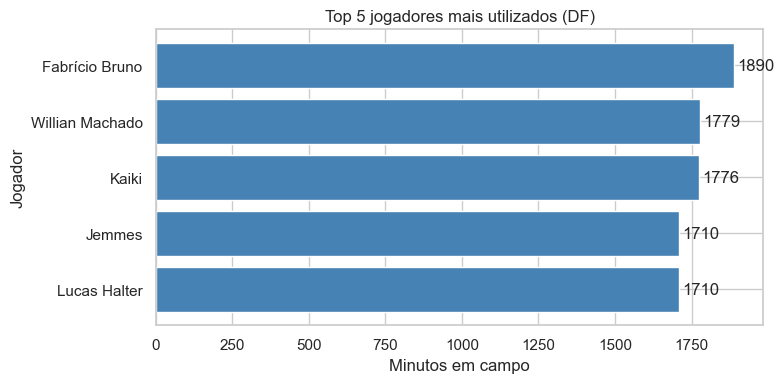

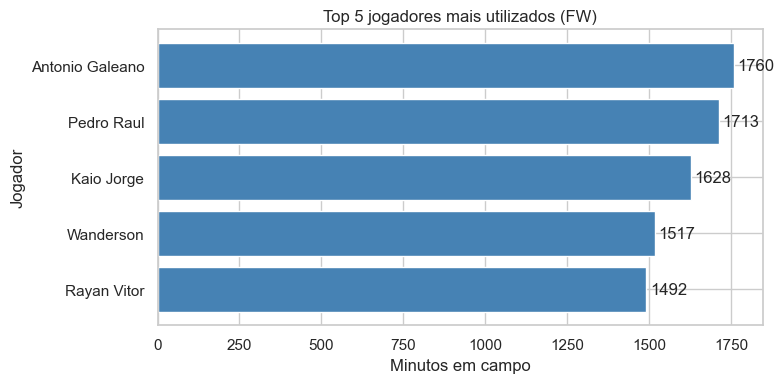

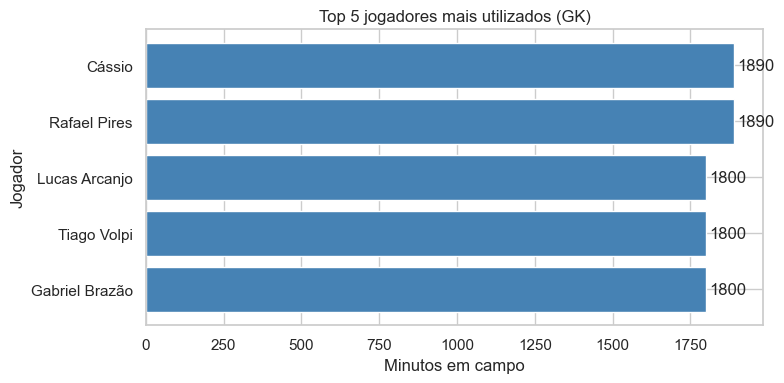

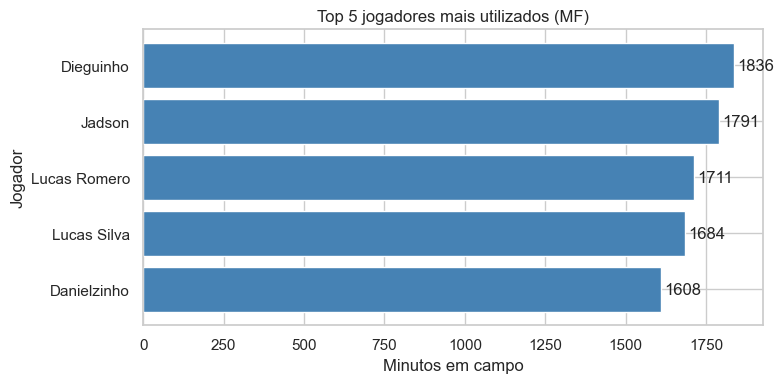

In [101]:
import matplotlib.pyplot as plt

def plot_top5_por_pos(df, n=5, min_minutos=0):
    d = df.copy()
    d["MP"]  = pd.to_numeric(d["MP"], errors="coerce")
    d["Min"] = pd.to_numeric(d["Min"], errors="coerce")
    d["Pos_simple"] = (
        d["Pos"].astype(str)
                .str.split(",|/|;")
                .str[0]
                .str.strip()
    )
    if min_minutos > 0:
        d = d[d["Min"] >= min_minutos]

    # Ordenar por posição e minutos
    d = d.sort_values(["Pos_simple","Min"], ascending=[True,False])

    # Top N por posição
    top5 = d.groupby("Pos_simple").head(n)

    # Plotar cada posição separada
    posicoes = top5["Pos_simple"].unique()
    for pos in posicoes:
        bloco = top5[top5["Pos_simple"] == pos].sort_values("Min", ascending=True)

        plt.figure(figsize=(8,4))
        plt.barh(bloco["Player"], bloco["Min"], color="steelblue")
        plt.title(f"Top {n} jogadores mais utilizados ({pos})")
        plt.xlabel("Minutos em campo")
        plt.ylabel("Jogador")

        # rótulos nos valores
        for i, v in enumerate(bloco["Min"]):
            plt.text(v + 10, i, str(int(v)), va="center")

        plt.tight_layout()
        plt.show()

# Executar
plot_top5_por_pos(serie_a, n=5, min_minutos=900)
